# Laboratory 2: Computer Vision

# Part 2: CNN for Pneumothorax Detection 

This second section of the lab will introduce you to using a convolutional network to tackle a realistic dataset in medical diagnostics. Specifically, we use the [ChestXRay dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community), a set of X-ray images labeled with corresponding diagnoses.

## 2.1 ChestXRay Dataset

The ChestXRay dataset consists of over 100,000 different X-rays from more than 30,000 patients labeled with different disease conditions. Our goal for this lab is to use a subset of the dataset to train a classifier that is able to accurately infer the presence of pneumothorax. 

Pneumothorax is a condition that occurs when there are abnormal amounts of air in the space between the lung and chest wall. This reduces the capacity to which the lung is able to expand and fill with air, leading to oxygen shortage and low blood pressure. Lack of treatment may lead to worsening symptoms and even death.

We provide two images: the image on the left does not have pneumothorax and the image on the right does have pneumothorax.

![alt text](img/pneumothorax.png "Pneumothorax Images")




In [1]:
import tensorflow as tf
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import uuid
from tqdm import tqdm

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's start by downloading the dataset. We provide a sample of the dataset in h5py format, where we extracted positive and negative examples of pneumothorax and downscaled images to $256 \times 256$ pixels.

In [2]:
import util.download_lung_data

Files have been downloaded.


Next, we need to define a class to hold the dataset. This class will allow us to access the training and test data separately. 

In [3]:
class PneumothoraxDataset:
    def __init__(self):
        print("Loading X-Ray Dataset!")

        train = h5py.File(util.download_lung_data.data_dir+'pneumothorax_train.h5','r')
        test = h5py.File(util.download_lung_data.data_dir+'pneumothorax_test.h5','r')

        self.X_train = train['image'][:]
        self.X_test = test['image'][:]
        self.Y_train = train['label'][:]
        self.Y_test = test['label'][:]

        self.num_train = self.X_train.shape[0]
        self.num_test = self.X_test.shape[0]

        self.batch_pointer = 0
        
    def getTotalNumDataPoints(self):
        return self.num_train+self.num_test
    
    def getTrainBatch(self, batch_size):
        inds = np.arange(self.batch_pointer,self.batch_pointer+batch_size)
        inds = np.mod( inds , self.num_train ) #cycle through dataset
        batch = (self.X_train[inds], self.Y_train[inds]) #grab batch

        self.batch_pointer += batch_size #increment counter before returning
        return batch

    def getTestBatch(self, batch_size):
        inds = np.random.choice(self.num_test, size=batch_size)
        return (self.X_test[inds], self.Y_test[inds])

Now, instantiate this class so we can make calls to it later.

In [4]:
'''TODO: Instantiate the class for this dataset.'''
data = PneumothoraxDataset() # TODO
print("Dataset consists of {} images".format(data.getTotalNumDataPoints()))

Loading X-Ray Dataset!
Dataset consists of 9964 images


## 2.2 Noisy Data!
This dataset contains a huge variety of patients and is extremely noisy (i.e., images taken from various angles, scales, illuminations). To demonstrate the difficulty of this dataset, we've randomly picked 4 training images of patients with (right) and without (left) a pneumothorax below.

![alt text](img/samples.png "Pneumothorax Images")

This X-Ray HAS a pneumothorax


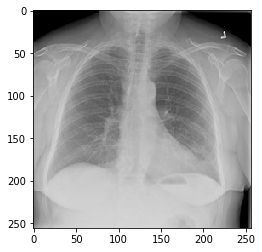

In [5]:
# TODO: Change value of INDEX here to visualize an image in the dataset!
INDEX = 410

image = data.X_train[INDEX]
label = data.Y_train[INDEX]
pred = np.argmax(label)

plt.imshow(image[:,:,0], cmap='gray')
print("This X-Ray "+("HAS" if pred else "DOES NOT have")+ " a pneumothorax")

## 2.3 Neural Network Model for Pneumothorax Detection
First let's start by importing the CNN model that we'll use to detect a pneumothorax.  We've provided this data in `models.py` - you are encouraged to experiment with changes inside this model to improve the accuracy and generalizability (however this is not necessary for this lab).

In [6]:
from util.models import PneumothoraxDetectionModel
model = PneumothoraxDetectionModel()

Like in Lab 1 we will need to define a set of hyperparameters to control training and testing our algorithm. Feel free to change them to see what works best!

In [7]:
batch_size = 15
learning_rate = 0.05
num_training_steps = int(1e6)

In [8]:
# Cost defines the empirical loss of the model given a set of labels and predictions. 
'''TODO: Fill in the cost function and arguments by looking at the model. Remember to keep track of logits!'''
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.y_, labels=model.y)) #TODO
optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True).minimize(cost)

Now we can define metrics to measure accuracy (percent correctly classified).

In [9]:
correct_prediction = tf.equal(tf.argmax(model.y_, 1), tf.argmax(model.y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
'''TODO: Fill in the model prediction.'''
prediction = tf.argmax(model.y_, 1)# TODO

**Tensorboard** is a tool to automatically plot and visualize the training process. You can periodically send "summaries" such as: 
* scalars (loss, accuracy, ...)
* images (photos, heatmaps, ...)
* distributions (weights, biases, activations, ...)

Let's set some simple scalar summaries to be plotted on Tensorboard (http://localhost:6006) - the plotting code below occurs during training.

In [10]:
tf.summary.scalar('cost',cost) 
tf.summary.scalar('accuracy',accuracy)

merged_summary_op = tf.summary.merge_all() #combine into a single summary which we can run on Tensorboard

In [11]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

### 2.3.1 Training (READ BEFORE RUNNING)
**Since this is a very large model, training for this large dataset takes a long time without GPU compute power. So, we have provided you with a model that was obtained by running the following cell. You don't have to run this cell!!!** 

In [ ]:
sess.run(init)
import uuid; #for tensorboard unique id
uniq_id = "./logs/lab2part2_"+uuid.uuid1().__str__()[:6]
summary_writer_train = tf.summary.FileWriter(uniq_id+'train', graph=tf.get_default_graph())
summary_writer_test = tf.summary.FileWriter(uniq_id+'test', graph=tf.get_default_graph())

for step in range(num_training_steps):
    (x_batch, y_batch) = data.getTrainBatch(batch_size) # get a training batch of data
    _, trainLoss, summary = sess.run([optimizer, cost, merged_summary_op],
                               feed_dict={model.x: x_batch, model.y:y_batch})

    summary_writer_train.add_summary(summary, step) 

    if step % 10 == 0:
        (x_test, y_test) = data.getTestBatch(100) # get a testing batch of data
        testLoss, testAcc, summary = sess.run([cost, accuracy, merged_summary_op], 
                                              feed_dict={model.x: x_test, model.y:y_test})

        print("step: {}, train: {}, \t\t test: {}, testAcc: {}".format(
              step, trainLoss, testLoss, int(testAcc*100)))
        summary_writer_test.add_summary(summary, step)

    if step % 100 == 0:
      save_path = saver.save(sess, uniq_id+'/model.ckpt')
      print("Model saved in file: %s" % save_path)

### 2.3.2 Load Trained Model
We've provided you with a network which we've trained using the code above. Run the line below to import it and continue with the lab.

In [14]:
#restore the weights from a trained model
saver = tf.train.Saver()
saver.restore(sess, "saved_model/model.ckpt") #only run this once!

INFO:tensorflow:Restoring parameters from saved_model/model.ckpt


### 2.3.3 Evaluating Results

Next we wish to evaluate our network on disease prediction of pneumothorax. In diagonostics, it is awkward to evaluate a network based off just pure prediction accuracy. Suppose for example, that our network were to predict all people to have disease. This network would then acheive 100% accuracy in predicting the disease but would be effectively useless.

Instead, to evaulate our network, we use the ROC score. In a ROC curve, we plot the positive predictive value (true positives / (true positives + false positives)) against the negative predictive value (true negatives / (true negatives + false negatives)). We can get different positive and negative prediction values by choosing a different confidence threshold at which we consider a disease to be postiive or negative. The area under the curve is then used as a metric to evaluate the quality of a model. Note that under this classification scheme, a model which assigns all outputs to be either positive or negative would have an area under the curve of effectively zero.

In [15]:
# Read the documentation of these functions online to find out their parameters and their outputs
from sklearn.metrics import roc_curve, auc

In [16]:
def compute_roc(y_true, y_score):
    """ Computes Receiving Operating Characteristic curve and area
    
    Params:
        - y_true: Ground truth binary labels
        - y_score: Continuous predictions in the range [0,1]
        
    Returns:
        - fpr: False Positive Rate at different thresholds
        - tpr: True Positive Rate at different thresholds
        - area: Area under the Receiving Operating Characteristic curve
    """
    '''TODO: Use the functions suggested above to fill in the ROC characteristics'''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)# TODO
    auroc = auc(fpr, tpr)# TODO
    return fpr, tpr, auroc

In [17]:
def plot_roc(y_true, y_score, title='Receiver operating characteristic example'):
    """ Plots Receiving Operating Characteristic curve
    
    Params:
        - y_true: Ground truth binary labels
        - y_score: Continuous predictions in the range [0,1]
    """
    fpr, tpr, auroc = compute_roc(y_true, y_score)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = {:.2f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

For computing the ROC metric we need the true labels of the examples along with the predictions of the network. True labels will be discrete (0:No Pneumothorax, 1:Pneumothorax). Predictions need to be continuous values in the range $[0,1]$ so we can sweep the threshold from 0 to 1 and get the True Postive Rate and False Positive Rate at each point. Since the output layer is a softmax of the two classes, we can interpret the continuous outputs as probabilities and use those directly for the ROC computation. 

In [18]:
# Compute test set predictions
NUMBER_TEST_SAMPLES = 100

y_true = []
y_score = []
for i in tqdm(range(NUMBER_TEST_SAMPLES)): #compute one at a time due to memory constraints
    y_true.extend( data.Y_test[[i],0] )
    probs = sess.run(model.probabilities, feed_dict={model.x: [data.X_test[i]]})
    y_score.extend( probs[:,0] )
    
correct = np.array(y_true) == np.round(y_score)

100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


In [19]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 70.00%


Now let's plot the results as an ROC curve!

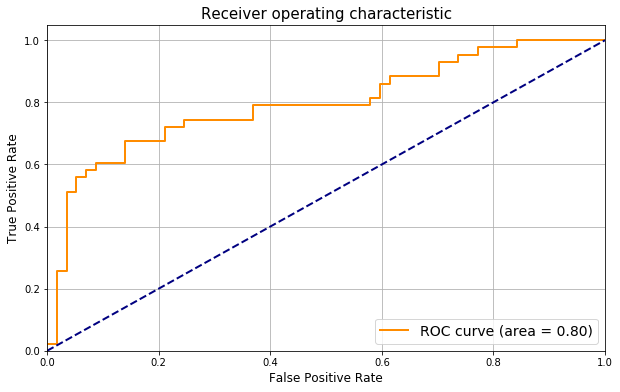

In [20]:
plot_roc(y_true, y_score, 'Receiver operating characteristic')

## 2.4 Interpreting the Neural Network's Output

Although CNNs are an effective tool for learning complex functional mappings, the large number of parameters that bestow such learning capacity often preclude interpretability. This lack of intepretability makes it difficult to analyze and debug complex neural models especially with our highly non-convex optimization landscape. Fortunately, the past few years have seen numerous advances in both theoretical and empirical analyses of CNNs, and in this section, we will explore some examples of the latter.

### 2.4.1 [Class Activation Mapping (CAM)](https://arxiv.org/pdf/1512.04150.pdf)

Class activation mapping (a technique developed [here at MIT](http://cnnlocalization.csail.mit.edu/)) generates "heatmaps" indicating the regions of the image to which our model "attends" in the final layers. Note that CAM visualization pertains to architectures with a global average pooling layer preceding the final FC/softmax layer. This is a common architectural choice for classification and localization tasks since it drastically reduces the parameter count of our network.

Given a single input image, let $f_k(x,y)$ represent the $k^{th}$ slice/channel of the feature map produced by the last convolution layer. Let $g_k = \sum_{x,y} {f_k(x,y)}$ denote the output of our global average pooling layer and $s_c = \sum_k {w_{c,k} g_k}$ denote the unnormalized class scores (logits) produced by the FC layer. Then, the class activation map for a given class $c'$ is given by

$$
m_c(x,y) = \sum_k {w_{c,k} \cdot f_k(x,y)}
$$

i.e., a dot product between the activations spanning the channel dimension of our final feature map with the FC weights for class $c$.

The weights $w_{c,k}$ denote the "importance" of the $k^{th}$ feature map in determining the class score. As a result, pixels with large activations in "important" layers are assigned greater weight in our class activation map.

<center><h1>   Can the neural network explain its decision?</h1></center>
![alt text](img/heatmap_example.png "Example Heatmap")

### 2.4.2 Preliminaries

In order to compute the CAM, we first need to extract the appropriate feature map from an input image. Examine how the `extract_features_weights` function below retrieves the final feature map (i.e., our $f_k$ values) and FC weights from our PneumothoraxDetectionModel model.

In [24]:
def extract_features_weights(sess, model):
    """ Extracts final feature maps and FC weights from trained model.
    
    Params:
        - sess: the current Tensorflow Session where the model was loaded
        - model: the PneumothoraxDetectionModel
    
    Returns (tuple):
        - an (_ x 16 x 16 x 512) tf.Tensor of activations from the final convolutional layer
        - an (512 x 2) tf.Tensor with the learned weights of the final FC layer
    """
    #access feature map activations directly from the model declaration
    feature_maps = model.skip4 
    
    #access the weights by searching by name
    dense_weights = sess.graph.get_tensor_by_name( os.path.split(model.y_.name)[0] + '/kernel:0')
    
    return (feature_maps, dense_weights)

In [25]:
'''TODO: extract the features and weights using the function defined directly above '''
(feature_maps, dense_weights) = extract_features_weights(sess, model)#TODO

In [26]:
print("Feature Maps: "+str(feature_maps))
print("Dense Weights: "+str(dense_weights))

Feature Maps: Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 16, 16, 512), dtype=float32)
Dense Weights: Tensor("dense/kernel:0", shape=(512, 2), dtype=float32_ref)


### 2.4.3 CAM Computation

Next, let's compute the CAM for a few sample images. In order to visualize the relevant image regions, we'll need to upsample our CAM to our image size. Complete the `compute_cam` and `upsample` functions below.

Hint: the `tf.image` module contains common image processing routines.

In [28]:
def compute_cam(class_index, fmap, weights):
    """ Forms a CAM operation given a class name, feature maps, and weights
    
    Params: 
        - class_index: index of the class to measure
        - fmap: (1 x 16 x 16 x 512) tf.Tensor of activations from the final convolutional layer
        - weights: (512 x 2) tf.Tensor with the learned weights of the final FC layer
    
    Returns: 
        - (16 x 16) tf.Tensor of downscaled CAMs  
    """
    w_vec = tf.expand_dims(weights[:, class_index], 1) 
    
    _, h, w, c = fmap.shape.as_list()
    fmap = tf.squeeze(fmap) # remove batch dim
    fmap = tf.reshape(fmap, [h * w, c])
    
    '''TODO: compute the CAM! Remeber to look at the equation defining CAMs above to do this '''
    CAM = tf.matmul(fmap, w_vec) # TODO
    CAM = tf.reshape(CAM, [1, h, w, 1])
    
    return CAM

In [29]:
'''TODO: compute the CAM for a pneumothorax detection (recall what class index this is) using the function above'''
cam = compute_cam(1, feature_maps, dense_weights)#TODO

In [30]:
def upsample(cam, im_hw):
    """ Upsamples CAM to appropriate size
    
    Params:
        - cam: a x_x_ tf.Tensor
        - im_hw: target size in [H, W] format
        
    Returns:
        - Upsampled CAM with size _xHxW
    """
    '''TODO: upsampling function call. Hint: look at resize functions in tf.image'''
    upsampled = tf.image.resize_bilinear(cam, im_hw) #TODO
    return upsampled

In [31]:
''' TODO: upsample the CAM Tensor to a 256\times 256 image using the function above '''
cam_upsampled = upsample(cam, [256,256])#TODO

### 2.4.4 CAM Heatmaps!
Finally, lets put everything together and compute and overlay the CAM heatmap on top of the X-Ray scan.

In [32]:
def vis_cam(image, cam, save_file=None):
    """ Visualize class activation heatmap, overlaying on image.
    
    Params:
        - image: ndarray of size
    """
    cam = (cam - cam.min()) / (cam.max() - cam.min()) 

    plt.imshow(255-image.squeeze(), cmap=plt.cm.gray, vmin=0, vmax=255) 
    plt.imshow(1-cam, cmap=plt.cm.jet, alpha=0.5, interpolation='nearest', vmin=0, vmax=1)
    
    if save_file:
        plt.savefig(save_file)
    
    plt.show()
    plt.close()

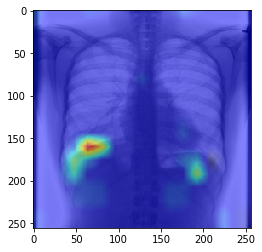

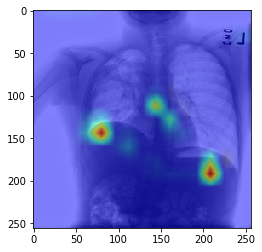

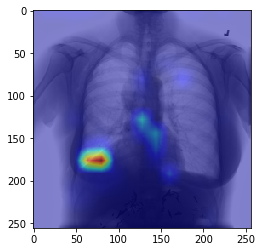

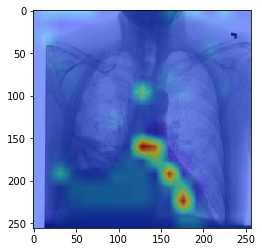

In [33]:
# Plot some sample x-rays, predictions, and CAMs overlayed ontop
inds = [37,45,29,30]
for im, cl in zip(data.X_test[inds], data.Y_test[inds]):

    heatmap = sess.run(
        cam_upsampled,
        feed_dict={
            model.x: im[np.newaxis, :, :],
        })

    vis_cam(im, np.squeeze(heatmap))

### 2.4.5 Things to Ponder: 
- Try to find examples of images where the model fails. Are these reasonable failures (difficult images)?
- When the model fails, what is it "looking" at? 
- Does the model ever "look" at points in the image that don't make sense? What are possible explanations of this?
- How can we make simple changes to the model to overcome some of these errors?